In [1]:
# 1. Import statements
import json
import networkx as nx
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from matplotlib.colors import to_hex, to_rgb
from datashader.bundling import hammer_bundle
import datashader.transfer_functions as tf
import datashader as ds
from tqdm import tqdm
from collections import defaultdict
from typing import Dict, Tuple, List, Optional, Union
from fa2_modified import ForceAtlas2
import warnings

import pandas as pd

pd.options.mode.chained_assignment = None

In [2]:
# 2. Constants and configuration
INPUT_GRAPH_PATH = "../data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
CLUSTER_INFO_LABEL_TREE = "../output/cluster-qualifications/ClusterInfoLabelTree.xlsx"
CLUSTER_LABEL_DICT_PATH = "../data/99-testdata/cluster_label_dict.json"
CLUSTER_TREE_PATH = "../output/cluster-qualifications/ClusterHierachy_noComments.json"
OUTPUT_DIR = "../data/99-testdata/"
THREEJS_OUTPUT_DIR = (
    "/Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/"
)
CLUSTER_HIERACHY_FOR_LEGEND_PATH = (
    "../output/cluster-qualifications/ClusterHierachy_noComments.json"
)

# utility functions


## Graph Reader


In [3]:
class GraphReader:
    @staticmethod
    def read_and_clean_graph(path: str) -> ig.Graph:
        g = ig.Graph.Read_GraphML(path)
        g.vs["node_id"] = ["n" + str(i) for i in range(g.vcount())]

        if "id" in g.vs.attribute_names():
            g.vs["node_name"] = g.vs["id"]
            del g.vs["id"]

        if "cluster" in g.vs.attribute_names():
            g.vs["cluster"] = [int(cluster) for cluster in g.vs["cluster"]]

        if "year" in g.vs.attribute_names():
            g.vs["year"] = [int(year) for year in g.vs["year"]]

        if "eid" in g.vs.attribute_names():
            del g.vs["eid"]

        if "centrality_alpha0.3_k10_res0.006" in g.vs.attribute_names():
            del g.vs["centrality_alpha0.3_k10_res0.006"]

        if "centrality_alpha0.3_k10_res0.002" in g.vs.attribute_names():
            g.vs["centrality"] = g.vs["centrality_alpha0.3_k10_res0.002"]
            del g.vs["centrality_alpha0.3_k10_res0.002"]

        g.es["edge_id"] = list(range(g.ecount()))
        print("Node Attributes:", g.vs.attribute_names())
        print("Edge Attributes:", g.es.attribute_names())
        # print number of nodes and edges
        print(f"Number of nodes: {g.vcount()}")
        print(f"Number of edges: {g.ecount()}")
        return g

    @staticmethod
    def subgraph_of_clusters(G, clusters):
        if isinstance(G, nx.Graph):
            nodes = [
                node for node in G.nodes if G.nodes[node].get("cluster") in clusters
            ]
            return G.subgraph(nodes)
        elif isinstance(G, ig.Graph):
            nodes = [v.index for v in G.vs if v["cluster"] in clusters]
            return G.subgraph(nodes)
        else:
            raise TypeError("Input must be a NetworkX Graph or an igraph Graph")

    @staticmethod
    def add_cluster_labels(
        G: Union[nx.Graph, ig.Graph],
        labels_file_path: str = "../output/cluster-qualifications/raw_cluster_labels.json",
    ) -> Tuple[Union[nx.Graph, ig.Graph], Dict[float, str]]:
        """
        Add cluster labels to the graph nodes.

        Args:
            G (Union[nx.Graph, ig.Graph]): The input graph (NetworkX or igraph).
            labels_file_path (str): Path to the JSON file containing cluster labels.

        Returns:
            Tuple[Union[nx.Graph, ig.Graph], Dict[float, str]]:
                The graph with added cluster labels and the cluster label dictionary.
        """
        with open(labels_file_path) as file:
            cluster_label_dict = json.load(file)
        cluster_label_dict = {float(k): v[0] for k, v in cluster_label_dict.items()}

        if isinstance(G, nx.Graph):
            for node in G.nodes:
                cluster = G.nodes[node]["cluster"]
                G.nodes[node]["cluster_label"] = cluster_label_dict.get(
                    cluster, "Unknown"
                )
        elif isinstance(G, ig.Graph):
            G.vs["cluster_label"] = [
                cluster_label_dict.get(v["cluster"], "Unknown") for v in G.vs
            ]
        else:
            raise TypeError("Input must be a NetworkX Graph or an igraph Graph")

        return G, cluster_label_dict

## LayoutUtility


In [4]:
class LayoutUtility:
    @staticmethod
    def fr_layout_nx(
        g: Union[nx.Graph, ig.Graph], layout_params: Optional[Dict] = None
    ) -> Tuple[nx.Graph, Dict]:
        if layout_params is None:
            layout_params = {
                # "k": 0.5, # distance between nodes; best to leave it to algo
                "iterations": 100,
                "threshold": 0.00001,  # default 0.0001
                "weight": "weight",
                "scale": 100,
                "center": (0, 0),
                "dim": 2,
                "seed": 1887,
            }
        if not isinstance(g, nx.Graph):
            G = g.to_networkx()
            print("Converted to NetworkX Graph")
        pos = nx.spring_layout(G, **layout_params)
        node_xy_dict = {node: pos[node] for node in G.nodes}

        x_values, y_values = zip(*node_xy_dict.values())
        min_x, max_x = min(x_values), max(x_values)
        min_y, max_y = min(y_values), max(y_values)

        print(f"Min x: {min_x}, Max x: {max_x}")
        print(f"Min y: {min_y}, Max y: {max_y}")

        for node in G.nodes:
            G.nodes[node]["x"] = node_xy_dict[node][0]
            G.nodes[node]["y"] = node_xy_dict[node][1]

        # g_nx = ig.Graph.from_networkx(G)
        return G, pos

## EdgeBundling


In [51]:
class EdgeBundling:
    @staticmethod
    def format_bundled_edges(
        bundled_edges_df: pd.DataFrame, edges_df: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Format the bundled edges dataframe.

        Args:
            bundled_edges_df (pd.DataFrame): The raw bundled edges dataframe.
            edges_df (pd.DataFrame): The original edges dataframe.

        Returns:
            pd.DataFrame: Formatted bundled edges dataframe.
        """
        bundled_edges_formatted = bundled_edges_df.dropna(how="all")
        bundled_edges_formatted["x_y"] = (
            bundled_edges_formatted["x"].astype(str)
            + ";"
            + bundled_edges_formatted["y"].astype(str)
        )
        bundled_edges_formatted = (
            bundled_edges_formatted.groupby("edge_id")["x_y"]
            .apply("|".join)
            .reset_index()
        )
        bundled_edges_formatted = bundled_edges_formatted.merge(
            edges_df, on="edge_id", how="left"
        )
        return bundled_edges_formatted

    @staticmethod
    def bundle_edges(
        graph: Union[nx.Graph, ig.Graph], bundle_kwargs: Optional[Dict] = None
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Bundle edges of the graph using the hammer_bundle algorithm.

        Args:
            graph (ig.Graph): The input graph.
            bundle_kwargs (Optional[Dict]): Keyword arguments for the hammer_bundle function.

            decay (default: 0.1):
            Range: Typically between 0 and 1
            Purpose: Controls how quickly the bundling effect diminishes over distance
            Higher values: Faster decay, less bundling over longer distances
            Lower values: Slower decay, more bundling even over longer distances

            initial_bandwidth (default: 0.25):
            Range: Typically between 0 and 1
            Purpose: Sets the initial radius of influence for edge bundling
            Higher values: Larger initial bundling radius, more aggressive initial bundling
            Lower values: Smaller initial bundling radius, more conservative initial bundling

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Raw bundled edges and formatted bundled edges.
        """
        if bundle_kwargs is None:
            bundle_kwargs = {
                "decay": 0.1,  # Increase decay if you want bundling to be more localized.
                "initial_bandwidth": 0.25,  # Increase initial_bandwidth if you want more aggressive bundling from the start.
                "iterations": 15,
                "include_edge_id": True,
            }

        # transform the graph if not igraph
        if not isinstance(graph, ig.Graph):
            graph = ig.Graph.from_networkx(graph)
            print("Converted to igraph Graph")

        df_nodes = pd.DataFrame(graph.get_vertex_dataframe())[["x", "y", "cluster"]]
        edges = [
            (edge.source, edge.target, edge["edge_id"], edge["weight"])
            for edge in graph.es
        ]
        edges_df = pd.DataFrame(
            edges, columns=["source", "target", "edge_id", "weight"]
        )

        try:
            bundled_edges = hammer_bundle(df_nodes, edges_df, **bundle_kwargs)
            bundled_edges = pd.DataFrame(
                bundled_edges, columns=["x", "y", "edge_id", "weight"]
            )
            formatted_bundled_edges = EdgeBundling.format_bundled_edges(
                bundled_edges, edges_df
            )
            return bundled_edges, formatted_bundled_edges
        except Exception as e:
            print(f"Error in edge bundling: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def prune_edges_by_median_weight(g: ig.Graph) -> ig.Graph:
        """
        Remove edges from the graph that have weight less than or equal to the median weight.

        This function removes approximately half of the edges from the graph, keeping all edges
        with weight greater than the median and randomly selecting from edges with exactly the
        median weight to reach the target number of edges.

        Args:
            g (ig.Graph): The input graph. Must have a 'weight' attribute for edges.

        Returns:
            ig.Graph: A new graph with approximately half of the original edges removed.

        Raises:
            ValueError: If the input graph has no 'weight' attribute for edges.

        Notes:
            - This function does not modify the input graph.
            - The function prints information about the number of edges and isolated vertices
            before and after the edge removal process.
        """

        # make igraph if networkx
        if not isinstance(g, ig.Graph):
            g = ig.Graph.from_networkx(g)
            print("Converted to igraph Graph")

        # Check if 'weight' attribute exists
        if "weight" not in g.es.attributes():
            raise ValueError("Input graph must have a 'weight' attribute for edges.")

        # Get initial number of edges and isolates
        initial_edge_count = g.ecount()
        initial_isolates = len(g.vs.select(_degree=0))

        # Get all weights and calculate the median
        weights = g.es["weight"]
        median_weight = np.median(weights)

        # Identify edges to keep
        edges_to_keep = [edge.index for edge in g.es if edge["weight"] > median_weight]
        median_edges = [edge.index for edge in g.es if edge["weight"] == median_weight]

        # Randomly select from median edges to reach target number of edges
        target_edge_count = initial_edge_count // 2
        edges_to_add = target_edge_count - len(edges_to_keep)
        if edges_to_add > 0:
            random.shuffle(median_edges)
            edges_to_keep.extend(median_edges[:edges_to_add])

        # Create a new graph with only the selected edges
        new_g = g.subgraph_edges(edges_to_keep, delete_vertices=False)

        # Get final number of edges and isolates
        final_edge_count = new_g.ecount()
        final_isolates = len(new_g.vs.select(_degree=0))

        # Print results
        print(
            f"Description of the distrbution of edge counts:\n{pd.Series(g.degree()).describe().round(0)}"
        )
        print("-" * 20)
        print(f"Number of edges before: {initial_edge_count}")
        print(f"Number of edges after: {final_edge_count}")
        print(f"Number of isolates before: {initial_isolates}")
        print(f"Number of isolates after: {final_isolates}")

        return new_g

## GraphSaver


In [6]:
class GraphSaver:
    @staticmethod
    def save_formatted_bundled_edges_to_json(
        formatted_bundled_edges: pd.DataFrame, path: str, return_json: bool = False
    ) -> Optional[List[Dict]]:
        """
        save the formatted bundled edges to a JSON file.

        Args:
            formatted_bundled_edges (pd.DataFrame): The formatted bundled edges dataframe.
            path (str): The path to save the JSON file.
            return_json (bool): Whether to return the JSON data.

        Returns:
            Optional[List[Dict]]: The JSON data if return_json is True.
        """

        def x_y_to_tuples(x_y):
            x_y = x_y.split("|")
            return [tuple(map(float, xy.split(";"))) for xy in x_y]

        edges_json = []
        for edge in formatted_bundled_edges.itertuples():
            edge_dict = {
                "edge_id": edge.edge_id,
                "source": edge.source,
                "target": edge.target,
                "weight": edge.weight,
                "x_y": x_y_to_tuples(edge.x_y),
            }
            edges_json.append(edge_dict)
        with open(path, "w") as f:
            json.dump(edges_json, f)
        print(f"Edges saved to {path}")
        if return_json:
            return edges_json

    @staticmethod
    def save_igraph_nodes_to_json(
        g: ig.Graph, path: str, return_json: bool = False, attributes: List[str] = None
    ) -> Optional[List[Dict]]:
        """
        Save the igraph nodes to a JSON file.
        """
        if attributes is None:
            attributes = [
                "node_id",
                "node_name",
                "doi",
                "year",
                "title",
                "cluster",
                "centrality",
                "x",
                "y",
            ]
        g.vs["title"] = [GraphUtility.fix_encoding(title) for title in g.vs["title"]]
        nodes_json = []
        for node in g.vs:
            if not all(attr in node.attributes() for attr in attributes):
                raise ValueError(f"Missing attribute in node: {node.attributes()}")
            node_dict = {attr: node[attr] for attr in attributes}
            nodes_json.append(node_dict)
        with open(path, "w") as f:
            json.dump(nodes_json, f)
        print(f"Graph saved to {path}")
        if return_json:
            return nodes_json

    @staticmethod
    def fix_encoding(title):
        decoded_title = title.encode("utf-8").decode("unicode_escape")
        return decoded_title.encode("latin1").decode("utf-8")

# VisualizationUtility


In [7]:
class VisualizationUtility:
    @staticmethod
    def plot_graph_with_bundled_edges(g, bundled_edges, **kwargs):
        """
        Plot the graph with bundled edges.
        Args:
        g (igraph.Graph or networkx.Graph): The graph object containing node positions and cluster information.
        bundled_edges (pd.DataFrame): DataFrame containing the bundled edge coordinates.
        **kwargs: Additional keyword arguments for customizing the plot.
            figsize (tuple): Figure size in inches. Default is (10, 10).
            node_size (int): Size of the nodes in the scatter plot. Default is 10.
            edge_alpha (float): Alpha (transparency) of the edges. Default is 0.2.
            edge_width (float): Width of the edge lines. Default is 0.2.
            node_alpha (float): Alpha (transparency) of the nodes. Default is 0.7.
            edge_color (str): Color of the edges. Default is "black".
            cmap (str): Colormap for the nodes. Default is "tab20".
        Returns:
        None: Displays the plot.
        """
        # Default values
        defaults = {
            "figsize": (10, 10),
            "node_size": 10,
            "edge_alpha": 0.2,
            "edge_width": 0.2,
            "node_alpha": 0.7,
            "edge_color": "black",
            "cmap": "tab20",
        }
        # transform the graph if not igraph
        if not isinstance(g, ig.Graph):
            g = ig.Graph.from_networkx(g)
            print("Converted to igraph Graph")

        # Update defaults with any provided kwargs
        defaults.update(kwargs)

        plt.figure(figsize=defaults["figsize"])

        # Plot edges
        plt.plot(
            bundled_edges["x"],
            bundled_edges["y"],
            color=defaults["edge_color"],
            alpha=defaults["edge_alpha"],
            linewidth=defaults["edge_width"],
        )

        # Get unique clusters and map them to consecutive integers
        unique_clusters = sorted(set(g.vs["cluster"]))
        cluster_map = {c: i for i, c in enumerate(unique_clusters)}

        # Map cluster values to consecutive integers
        cluster_colors = [cluster_map[c] for c in g.vs["cluster"]]

        # Create a custom colormap
        cmap = plt.get_cmap(defaults["cmap"])
        n_colors = len(unique_clusters)
        custom_cmap = cmap(np.linspace(0, 1, n_colors))

        # Plot nodes
        scatter = plt.scatter(
            g.vs["x"],
            g.vs["y"],
            s=defaults["node_size"],
            c=cluster_colors,
            cmap=cmap,
            alpha=defaults["node_alpha"],
        )

        # Add a colorbar
        # plt.colorbar(scatter, label="Cluster", ticks=range(len(unique_clusters)))
        # plt.clim(-0.5, len(unique_clusters) - 0.5)

        plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Draw the network

# 2D - Fruchterman Reingold - Bundled Edges


In [40]:
g = GraphReader.read_and_clean_graph(INPUT_GRAPH_PATH)

# subset to only cluster 1 to 10
g = GraphReader.subgraph_of_clusters(g, [10, 11, 12, 100])

Node Attributes: ['doi', 'year', 'title', 'cluster', 'node_id', 'node_name', 'centrality']
Edge Attributes: ['weight', 'edge_id']
Number of nodes: 40643
Number of edges: 602779


/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_46872/6105614.py:4: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g = ig.Graph.Read_GraphML(path)


In [41]:
g_fr, pos = LayoutUtility.fr_layout_nx(g)

Converted to NetworkX Graph
Min x: -99.48757934570312, Max x: 91.5522689819336
Min y: -100.0, Max y: 90.947021484375


In [42]:
bundled_edges, formatted_bundled_edges = EdgeBundling.bundle_edges(g_fr)

print(f"Nr of edges before bundling: {len(list(g_fr.edges()))}")
print(f"Nr of edges after bundling: {bundled_edges.shape[0]}")
print(f"Nr of edges in formatted df: {formatted_bundled_edges.shape[0]}")

Converted to igraph Graph
Nr of edges before bundling: 19145
Nr of edges after bundling: 177032
Nr of edges in formatted df: 19145


Converted to igraph Graph


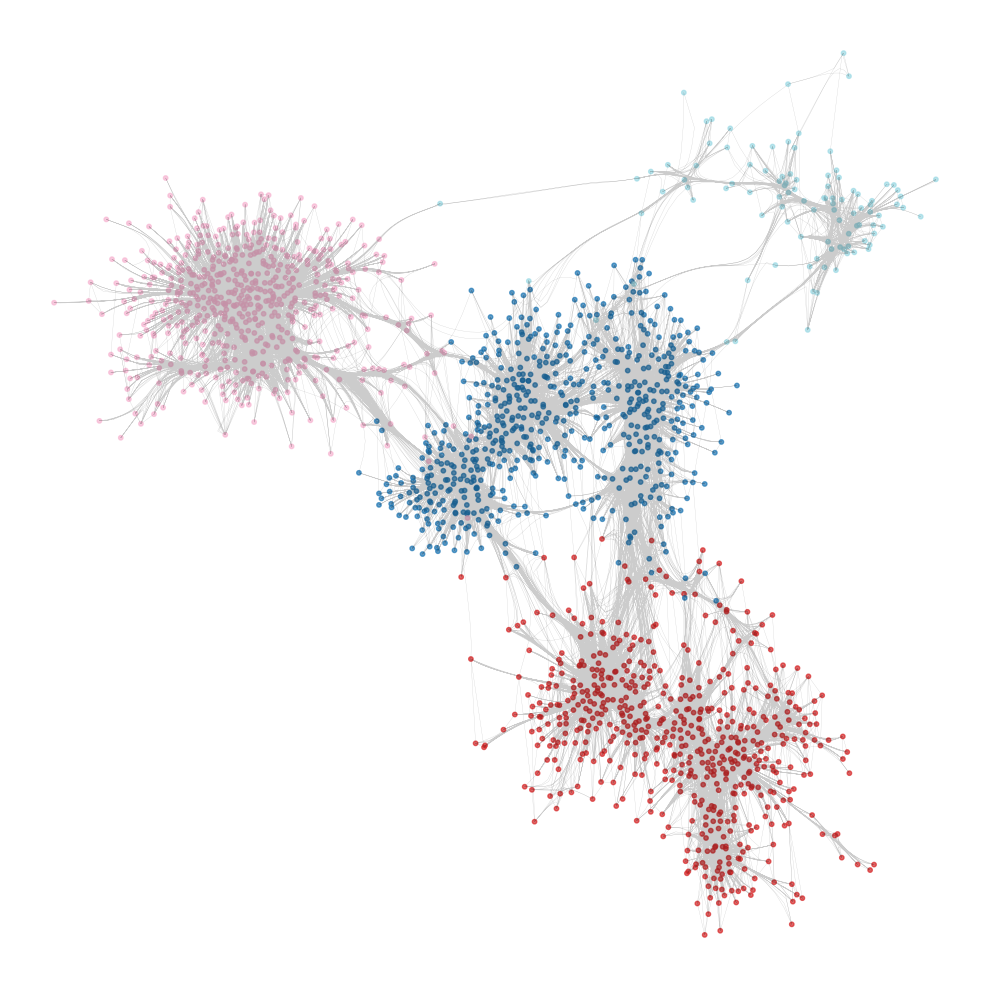

In [43]:
VisualizationUtility.plot_graph_with_bundled_edges(g_fr, bundled_edges)

# To DO:

1. get number of edges per node
2. limit number of edges to 50% per node, only keep highest weights.
3. only use this for the visualization!
4. save the selection of edges


In [18]:
# g = GraphReader.read_and_clean_graph(INPUT_GRAPH_PATH)

# subset clusters
# g_sub = GraphReader.subgraph_of_clusters(g, [10, 11, 12, 100])

Node Attributes: ['doi', 'year', 'title', 'cluster', 'node_id', 'node_name', 'centrality']
Edge Attributes: ['weight', 'edge_id']
Number of nodes: 40643
Number of edges: 602779


/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_46872/6105614.py:4: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g = ig.Graph.Read_GraphML(path)


Converted to igraph Graph
Description of the distrbution of edge counts:
count    1894.0
mean       20.0
std        16.0
min         2.0
25%        10.0
50%        15.0
75%        24.0
max       147.0
dtype: float64
--------------------
Number of edges before: 19145
Number of edges after: 9572
Number of isolates before: 0
Number of isolates after: 14


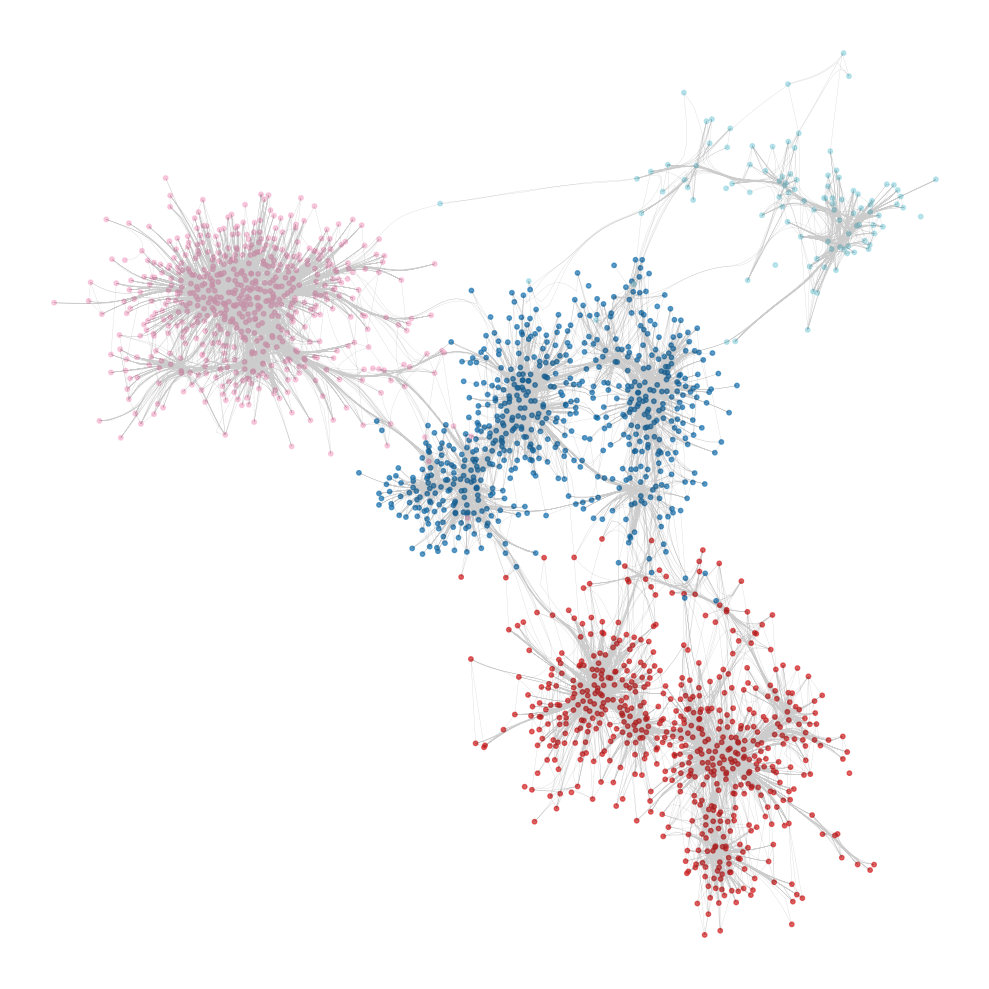

In [59]:
g_sub_edge_pruned = EdgeBundling.prune_edges_by_median_weight(g_fr)


bundled_edges, formatted_bundled_edges = EdgeBundling.bundle_edges(g_sub_edge_pruned)

# print(f"Nr of edges before bundling: {len(list(g_sub_edge_pruned.edges()))}")
# print(f"Nr of edges after bundling: {bundled_edges.shape[0]}")
# print(f"Nr of edges in formatted df: {formatted_bundled_edges.shape[0]}")

VisualizationUtility.plot_graph_with_bundled_edges(g_sub_edge_pruned, bundled_edges)

# 3D Visualization


In [ ]:
class GraphProcessor3d:
    def __init__(self, G: Union[nx.Graph, ig.Graph]):
        self.g = self._ensure_igraph(G)

    @staticmethod
    def _ensure_igraph(G: Union[nx.Graph, ig.Graph]) -> ig.Graph:
        if isinstance(G, nx.Graph):
            return ig.Graph.from_networkx(G)
        return G

    def apply_layout(self, layout_name: str = "fruchterman_reingold_3d", **kwargs):
        """
        Apply a layout to the graph. For Fruchterman-Reingold 3D, available kwargs are:
        - dim: The dimension of the layout (default: 3)
        - weights: Edge weights to be used. Can be a list or the name of an edge attribute.
        - niter: The number of iterations to perform (default: 500)
        - start_temp: The starting temperature (default: 10)
        - seed: Random seed to use (default: None)
        """
        if layout_name == "fruchterman_reingold_3d":
            # Set default values
            layout_kwargs = {
                "dim": 3,
                "weights": "weight",
                "niter": 500,
                "start_temp": 10,
                "seed": None,
            }
            # Update with provided kwargs
            layout_kwargs.update(kwargs)

            layout = self.g.layout_fruchterman_reingold_3d(**layout_kwargs)
        else:
            layout = self.g.layout(layout_name, **kwargs)

        for i, coords in enumerate(layout):
            self.g.vs[i]["x"] = coords[0]
            self.g.vs[i]["y"] = coords[1]
            self.g.vs[i]["z"] = coords[2]

        print(f"Layout {layout_name} applied to the graph.")
        print("Coordinates stored in node attributes.")
        return self.g


# example usage
gp3d = GraphProcessor3d(g)
g = gp3d.apply_layout("fruchterman_reingold_3d")

Layout fruchterman_reingold_3d applied to the graph.
Coordinates stored in node attributes.


KeyboardInterrupt: 

# color and label assignment for full graph


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import to_hex
from matplotlib.colors import to_rgb

In [ ]:
class ClusterColorAssigner:
    """
    TO DO:
    1. clusters not mutually exclusive - need to assign to multiple categories
    2. colors too similar - need to assign more distinct colors

    A class for assigning colors to clusters based on their characteristics.

    This class provides methods to categorize clusters into color palettes,
    assign specific colors within those palettes, and create a mapping
    between clusters and their assigned colors.

    Attributes:
        colormaps (dict): A dictionary mapping color names to matplotlib colormaps.
        condition_names (dict): A dictionary mapping color names to condition names.

    Methods:
        assign_color_categories(clust_hierarchy): Assigns color categories to clusters.
        print_color_mapping(): Prints the mapping of conditions to color palettes.
        assign_colors(df, colormap): Assigns specific colors to clusters within a palette.
        create_color_dataframes(clust_hierarchy): Creates separate DataFrames for each color category.
        process_cluster_hierarchy(clust_hierarchy): Processes the entire cluster hierarchy.

    Usage:
        color_assigner = ClusterColorAssigner()
        processed_hierarchy, color_dict = color_assigner.process_cluster_hierarchy(cluster_hierarchy_df)
    """

    def __init__(self):
        self.colormaps = {
            "blue": plt.get_cmap("Blues"),
            "red": plt.get_cmap("Reds"),
            "green": plt.get_cmap("Greens"),
            "purple": plt.get_cmap("Purples"),
        }
        self.condition_names = {
            "blue": "pharmacology",
            "red": "indications",
            "green": "safety",
            "purple": "other",
        }

    def assign_color_categories(self, clust_hierarchy):
        conditions = [
            clust_hierarchy["pharmacology"] == 1,
            clust_hierarchy["indications"] == 1,
            clust_hierarchy["safety"] == 1,
            clust_hierarchy["other"] == 1,
        ]
        choices = ["blue", "red", "green", "purple"]
        clust_hierarchy["color_pal"] = np.select(conditions, choices, default="")
        return clust_hierarchy

    def print_color_mapping(self):
        print("Mapping of conditions to color palettes:")
        for color, condition in self.condition_names.items():
            print(f"{condition.capitalize()}: {color}")

    @staticmethod
    def assign_colors(df, colormap):
        num_colors = df.shape[0]
        colors = [to_hex(colormap(x)) for x in np.linspace(0.1, 0.9, num_colors)]
        df["color"] = colors
        return df

    def create_color_dataframes(self, clust_hierarchy):
        color_dfs = {}
        for color_name, colormap in self.colormaps.items():
            df_color = clust_hierarchy[
                clust_hierarchy["color_pal"] == color_name
            ].copy()
            if not df_color.empty:
                color_dfs[color_name] = self.assign_colors(df_color, colormap)
        return color_dfs

    def process_cluster_hierarchy(self, clust_hierarchy):
        clust_hierarchy = self.assign_color_categories(clust_hierarchy)
        self.print_color_mapping()
        color_dfs = self.create_color_dataframes(clust_hierarchy)
        clust_hierarchy = pd.concat(color_dfs.values())
        cluster_color_dict = dict(
            zip(clust_hierarchy["cluster"], clust_hierarchy["color"])
        )
        return clust_hierarchy, cluster_color_dict

    def save_dict_to_json(self, dict, path):
        with open(path, "w") as f:
            json.dump(dict, f)
        print(f"Cluster color dictionary saved to {path}")

In [ ]:
# Assuming clust_hierarchy is your input DataFrame

clust_hierarchy = pd.read_excel(CLUSTER_INFO_LABEL_TREE)

color_assigner = ClusterColorAssigner()
clust_hierarchy, cluster_color_dict = color_assigner.process_cluster_hierarchy(
    clust_hierarchy
)

color_assigner.save_dict_to_json(
    cluster_color_dict, OUTPUT_DIR + "cluster_color_dict.json"
)

cluster_label_dict = dict(
    zip(clust_hierarchy["cluster"], clust_hierarchy["clusterlabel"])
)

color_assigner.save_dict_to_json(cluster_label_dict, CLUSTER_LABEL_DICT_PATH)

print("\nCluster color dictionary (first 5 items):")
print(dict(list(cluster_color_dict.items())[:5]))
print("\nCluster label dictionary (first 5 items):")
print(dict(list(cluster_label_dict.items())[:5]))

Mapping of conditions to color palettes:
Pharmacology: blue
Indications: red
Safety: green
Other: purple
Cluster color dictionary saved to ../data/99-testdata/cluster_color_dict.json
Cluster color dictionary saved to ../data/99-testdata/cluster_label_dict.json

Cluster color dictionary (first 5 items):
{0: '#e3eef9', 2: '#dfebf7', 3: '#dbe9f6', 5: '#d6e6f4', 6: '#d3e3f3'}

Cluster label dictionary (first 5 items):
{0: 'Serotonin Receptor Studies', 2: 'Risks of Prenatal Exposure', 3: 'Quantification of SSRIs in Biological Samples', 5: 'SSRIs and the Cytochrome P450 System', 6: 'SSRI Neuroscience'}


# legend json creation


In [ ]:
def transform_dict_to_legend(cluster_hierachy_dict, cluster_label_dict):
    """
    Adds the cluster labels to the cluster hierarchy dictionary to create a legend.
    """
    # make sure keys in cluster_label_dict are integers
    cluster_label_dict = {int(k): v for k, v in cluster_label_dict.items()}
    legend = cluster_hierachy_dict.copy()
    for key, value in legend.items():
        if isinstance(value, dict):
            # Recursively transform dictionaries
            transform_dict(value, cluster_label_dict)
        elif isinstance(value, list):
            new_list = []
            for item in value:
                if isinstance(item, int) and item in cluster_label_dict:
                    new_list.append({item: cluster_label_dict[item]})
                else:
                    new_list.append(item)
            legend[key] = new_list
    return legend


with open(CLUSTER_HIERACHY_FOR_LEGEND_PATH, "r") as f:
    cluster_hierachy_dict = json.load(f)

with open(CLUSTER_LABEL_DICT_PATH, "r") as f:
    cluster_label_dict = json.load(f)

legend = transform_dict_to_legend(cluster_hierachy_dict, cluster_label_dict)

In [ ]:
legend

{'Pharmacology': {'Pharmacodynamics': {'Mechanism of action': [{0: 'Serotonin Receptor Studies'},
    {10: 'Paroxetine Bindeing'},
    {19: 'SSRIs Effect on Fear'},
    {11: 'SSRIs Effect on Neural Processing of Emotional Cues'},
    {30: 'Serotonin Binding and Receptor Studies'},
    {81: 'Astrocyte Receptors'},
    {88: 'Repeated SSRIs Exposures Effects on Dopamine Receptors'},
    {90: 'Neurochemical and Electrophysiological Correlates of SSRIs'},
    {94: 'SSRIs for OCD-like behaviors'},
    {112: 'SSRIs in Model Organisms ( C. Elegans and Drosophilia)'},
    {120: 'Tryptophan Depletion in Depression'}],
   'Animal Models of Disorders': [{8: 'The Chronic Unpredictable Mild Stress Model of Depression'},
    {14: 'SSRIs in Forced Swimming Test'},
    {109: 'SSRIs Effect on Response Inhibition'},
    {123: 'Olfactory Bulbectomized (OB) Rat Model for Depression'}],
   'OtherPharmacodynamics': [{6: 'SSRI Neuroscience'},
    {64: 'SSRIs Effects on Ion Channels'},
    {65: 'Methylenedioxy

In [ ]:
# Save as JSON
with open(OUTPUT_DIR + "legend_full_label_tree_clusternr.json", "w") as json_file:
    json.dump(cat_tree, json_file, indent=4)

    # Save as JSON
with open(
    THREEJS_OUTPUT_DIR + "legend_tree.json",
    "w",
) as json_file:
    json.dump(cat_tree, json_file, indent=4)